In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt


etymology = pd.read_csv('etymology.csv')
#df = etymology[etymology['lang'] == 'English']
#engl = df.drop(['lang', 'term_id', 'related_term_id', 'position', 'group_tag', 'parent_tag', 'parent_position'], axis = 1)

In [145]:
# RNN
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from gensim.models import Word2Vec
import gensim

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

all_letters = {
    "a": 0,
    "b": 1,
    "c": 2,
    "d": 3,
    "e": 4,
    "f": 5,
    "g": 6,
    "h": 7,
    "i": 8,
    "j": 9,
    "k": 10,
    "l": 11,
    "m": 12,
    "n": 13,
    "o": 14,
    "p": 15,
    "q": 16,
    "r": 17,
    "s": 18,
    "t": 19,
    "u": 20,
    "v": 21,
    "w": 22,
    "x": 23,
    "y": 24,
    "z": 25,
    "à": 26,
    "ợ": 27,
    " ": 28
}
n_letters = 29

def letterToIndex(letter):
    return all_letters[letter] if letter in all_letters else -1

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('jones').size())

torch.Size([5, 1, 29])


In [146]:
def combineLangs(word):
  word = word.lower()
  if "latin" in word:
    return "latin"
  elif "greek" in word:
    return "greek"
  elif "french" in word:
    return "french"
  elif "german" in word:
    return "german"
  elif "italian" in word:
    return "italian"
  elif "swedish" in word:
    return "swedish"
  elif "irish" in word:
    return "irish"
  elif "english" in word:
    return "english"
  elif "dutch" in word:
    return "dutch"
  elif "turkish" in word:
    return "turkish"
  elif "norwegian" in word:
    return "norwegian"
  elif "frisian" in word:
    return "frisian"
  else:
    return word

class LinguisticRegions:
  def __init__(self):
        self.families = {
            "europe_east": {
                "languages": [
                    "proto-indo-european", "greek", "yiddish", "polish", "russian", "czech", "albanian",
                    "ukrainian", "armenian", "lithuanian", "proto-slavic", "belariusian", "slovene", "proto-slavic"
                    "latvian", "slovak", "turkish",
                 ],
            },
            "europe_west": {
                "languages": [
                    "latin", "french", "irish", "anglo-norman", "english", "german", "dutch", "scottish gaelic",
                    "scots", "portuguese", "spanish", "italian", "welsh", "frankish", "proto-celtic", "catalan",
                    "norman", "breton", "cornish", "proto-brythonic", "old breton", "lombardic"
                ]
            },
            "europe_north": {
                "languages": [
                    "old norse", "swedish", "norwegian", "danish", "icelandic", "norwegian", "frisian", "gothic",
                    "old saxon", "northern sami"
                ]
            },
            "asia_east": {
                "languages": [
                    "japanese", "malay", "chinese", "korean", "mandarin", "tagalog", "vietnamese", "cantonese",
                    "min nan", "mongolian"
                ]
            },
            "asia_south": {
                "languages": [
                    "sanskrit", "urdu", "hindi", "tamil", "thai", "bengali", "tibetan", "indonesian"
                ]
            },
            "africa_south": {
                "languages": [
                    "afrikaans", "zulu"
                ]
            },
            "africa_north": {
                "languages": [
                    "egyptian", "swahili", "algerian arabic",
                ]
            },
            "middle_east": {
                "languages": [
                    "hebrew", "arabic", "persian", "old persian", "akkadian"
                ]
            },
            "central_america": {
                "languages": [
                    "classical nahuatl", "nahuatl"
                ]
            }
        }

  def get_families(self):
      obj = {}
      index = 0
      for x in list(self.families.keys()):
        for y in self.families[x]["common_characters"]:
          obj[y] = index
          index += 1
      return obj

# more precise regions
def getRegionPrecise(lang):
  lang = lang.lower()
  for family in lrs.families.keys():
    if lang in lrs.families[family]["languages"]:
      return family

  return "unknown region"

# general regions
def getRegionGeneral(lang):
  lang = lang.lower()
  if lang in lrs.families["europe_east"]["languages"] or lang in lrs.families["europe_west"]["languages"] or lang in lrs.families["europe_north"]["languages"]:
    return "europe"
  elif lang in lrs.families["asia_east"]["languages"] or lang in lrs.families["asia_south"]["languages"]:
    return "asia"
  elif lang in lrs.families["africa_north"]["languages"] or lang in lrs.families["africa_south"]["languages"]:
    return "africa"
  elif lang in lrs.families["middle_east"]["languages"]:
    return "middle east"
  elif lang in lrs.families["central_america"]["languages"]:
    return "central america"

  return "unknown region"

lrs = LinguisticRegions()

In [147]:
# preprocessing

# getting a sample since it takes really long with the entire set
#limited = engl #.sample(60000)

# these languages use similar alphabets to English
limited = etymology[(etymology['lang'] == 'English') | (etymology['lang'] == 'German') | (etymology['lang'] == 'Spanish') | (etymology['lang'] == 'Italian') | (etymology['lang'] == 'Vietnamese') | (etymology['lang'] == 'Indonesian')]
limited = limited.drop(['lang', 'term_id', 'related_term_id', 'position', 'group_tag', 'parent_tag', 'parent_position'], axis = 1)
limited = limited.dropna()
print("unique words =", len(limited["term"].unique()))

# combine languages (ie ancient greek -> greek, old english -> english)
limited["related_lang"] = limited["related_lang"].apply(combineLangs)

# select higher frequency languages
frequency = limited['related_lang'].value_counts()
limited['frequency'] = limited['related_lang'].map(frequency)
limited.loc[limited['frequency'] < 10, 'related_lang'] = 'uncommon'
print("unique related languages =", len(limited["related_lang"].unique()))

# filter words that are short
limited = limited[limited["term"].str.len() > 3]

# make everything lowercase
limited["term"] = limited["term"].str.lower()

# reduce each term to it's most frequent related_lang
'''
print("before", len(limited))
count_df = limited.groupby(["term", "related_lang"]).size().reset_index(name="count")
most_common = count_df.loc[count_df.groupby('term')['count'].idxmax()]
limited = pd.merge(limited, most_common[['term', 'related_lang']], on=['term', 'related_lang'])
print("after", len(limited))
'''

# get the region for each language
limited["region"] = limited["related_lang"].apply(lambda x: getRegionGeneral(x)) # replace this with getRegionGeneral or getRegionPrecise

# remove unknown regions
limited = limited[limited["region"] != "unknown region"]

# select from a specific reltype?
limited = limited[limited["reltype"] == "etymologically_related_to"]
#limited = limited[limited["reltype"] == "derived_from"]

#print("data available after processing =", len(limited))
#limited = limited.sample(100000)

# get labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(limited['region'])
print("labels", encoder.classes_)
n_categories = len(encoder.classes_)
all_categories = encoder.classes_.tolist()

print("final data count", len(limited))

#X_train, X_test, y_train, y_test = train_test_split(result_df, labels, test_size = test_size, random_state = seed)



unique words = 493440
unique related languages = 330
labels ['africa' 'asia' 'central america' 'europe' 'middle east']
final data count 136784


In [163]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [164]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [165]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# giving europe a higher chance to be selected
better_categories = [*all_categories, "europe", "europe"]

terms = {}
for region in all_categories:
  terms[region] = limited[limited["region"] == region]["term"].values

def randomTrainingExample():
    category = randomChoice(better_categories)
    #line = randomChoice(limited[limited["region"] == category]["term"].values)
    line = randomChoice(terms[category])
    '''
    line = limited.sample(1)
    category = line["region"].values[0]
    term = line["term"].values[0]
    '''
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('related term region =', category, '/ word =', line)

related term region = central america / word = zapotec
related term region = middle east / word = bracha
related term region = europe / word = wirepuller
related term region = europe / word = under the weather
related term region = central america / word = tlaxcala
related term region = asia / word = sulk
related term region = asia / word = tarka
related term region = middle east / word = cipher
related term region = africa / word = afterclap
related term region = central america / word = paliacate


In [166]:
import time
import math

n_iters = 20000
print_every = 500
plot_every = 500

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        #guess, guess_i = categoryFromOutput(output)
        print(timeSince(start), str(iter) + "/" + str(n_iters), "loss:", current_loss / plot_every)
        #correct = '✓' if guess == category else '✗ (%s)' % category
        #print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

0m 1s 500/20000 loss: 1.4357597070932389
0m 2s 1000/20000 loss: 1.4729035410881042
0m 3s 1500/20000 loss: 1.376287968993187
0m 4s 2000/20000 loss: 1.3072273831367494
0m 5s 2500/20000 loss: 1.2282223174273967
0m 6s 3000/20000 loss: 1.2236246595084668
0m 8s 3500/20000 loss: 1.119788611203432
0m 9s 4000/20000 loss: 1.1298937548771502
0m 11s 4500/20000 loss: 1.109079977877438
0m 12s 5000/20000 loss: 1.0223575719445943
0m 13s 5500/20000 loss: 1.0674387348517775
0m 14s 6000/20000 loss: 1.0168003833778203
0m 15s 6500/20000 loss: 1.014099778275937
0m 16s 7000/20000 loss: 0.9503876793496311
0m 17s 7500/20000 loss: 0.9504697736874222
0m 18s 8000/20000 loss: 1.0297078153789043
0m 19s 8500/20000 loss: 0.9668419149741531
0m 20s 9000/20000 loss: 1.000993147071451
0m 22s 9500/20000 loss: 0.9393420968577266
0m 23s 10000/20000 loss: 0.8598171914629639
0m 25s 10500/20000 loss: 0.9069422258082778
0m 27s 11000/20000 loss: 0.8631251152129844
0m 28s 11500/20000 loss: 0.8886279786741361
0m 29s 12000/20000 lo

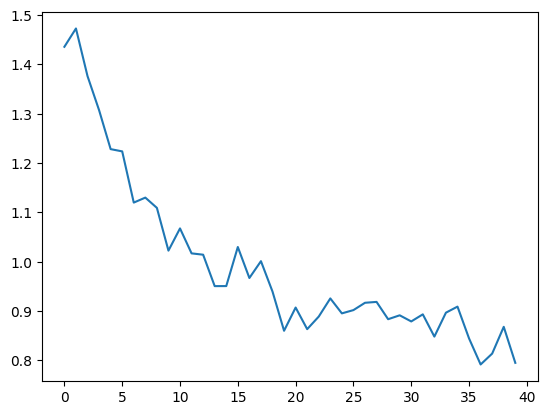

In [167]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [168]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 2000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
total = 0
correct = 0
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    total += 1
    correct += 1 if guess == category else 0
    confusion[category_i][guess_i] += 1

print("correct =", correct, "/", total)
print("Total words africa:", len(limited[limited["region"] == "africa"]))
print("Total words asia:", len(limited[limited["region"] == "asia"]))
print("Total words central america:", len(limited[limited["region"] == "central america"]))
print("Total words europe:", len(limited[limited["region"] == "europe"]))
print("Total words middle east:", len(limited[limited["region"] == "middle east"]))


correct = 1359 / 2000
Total words africa: 168
Total words asia: 3912
Total words central america: 275
Total words europe: 131227
Total words middle east: 1202


<ipython-input-172-6f4f54481151>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-172-6f4f54481151>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


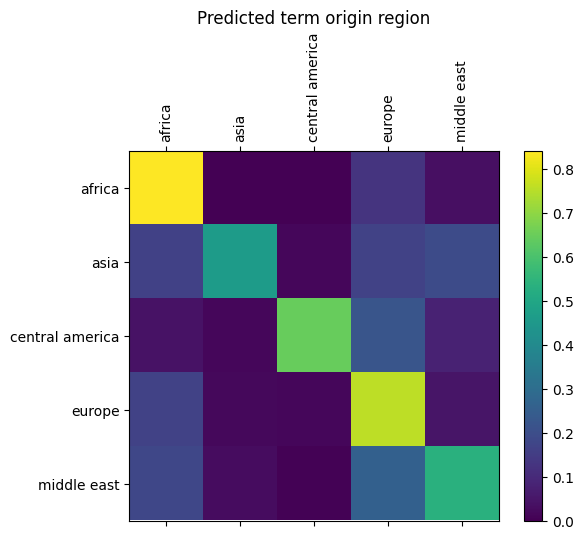

In [172]:

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.title("Predicted term origin region")

# sphinx_gallery_thumbnail_number = 2
plt.show()